In [1]:
%matplotlib inline
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn import linear_model

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR, LinearSVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import lightgbm as lgbm

from keras.models import Sequential
from keras.layers import Dense

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import datetime 
import os

/usr/local/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.
/usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a s

In [2]:
vids = pd.read_csv('vids.csv')
vids = vids.dropna()
X = vids[vids.category_id.notna()]
X = X.drop(([
    'video_id', 'channel_title', 'trending_date', 'comment_count', 
    'likes', 'dislikes', 'video_error_or_removed', 'thumbnail_link',]), 1)
Y = vids.views

In [3]:
encoded_cateogries = pd.get_dummies(X.category_id, prefix="category_id")
X = X.drop(['category_id'], 1)
for column in encoded_cateogries.columns:
    X[column] = encoded_cateogries[column]

In [4]:
def publish_time_to_day(day_string):
    try:
        split = day_string.split('T')[0].split('-')
        return datetime.datetime(int(split[0]), int(split[1]), int(split[2])).strftime('%A')
    except:
        return 'Monday'

X['publish_day'] = X.publish_time.apply(publish_time_to_day)
encoded_cateogries = pd.get_dummies(X.publish_day, prefix="publish_day")
for column in encoded_cateogries.columns:
    X[column] = encoded_cateogries[column]
X = X.drop(['publish_time', 'publish_day'], 1)

In [5]:
processed_titles = []
processed_descriptions = []
processed_tags = []

for i in tqdm(range(len(X))):
    try:
        processed_titles.append(simple_preprocess(X.title.iloc[i]))
    except:
        processed_titles.append([""])

    try:
        processed_descriptions.append(simple_preprocess(X.description.iloc[i]))
    except:
        processed_descriptions.append([""])

    try:
        processed_tags.append(simple_preprocess(X.tags.iloc[i]))
    except:
        processed_tags.append([""])

In [6]:
w2v_model = Word2Vec.load(os.path.join('mdl', 'word2vec.model'))
all_one_feature = []
dscription_feature = []
title_feature = []
tags_feature = []

for i in tqdm(range(len(X))):
    filtered = [word for word in processed_titles[i] if word in w2v_model.wv.vocab]
    if len(filtered) > 0:
        title_vec = np.mean(w2v_model.wv[filtered], axis=0)
    else:
        title_vec = np.zeros(w2v_model.vector_size)
        
    filtered = [word for word in processed_descriptions[i] if word in w2v_model.wv.vocab]
    if len(filtered) > 0:
        description_vec = np.mean(w2v_model.wv[filtered], axis=0)
    else:
        description_vec = np.zeros(w2v_model.vector_size)
        
    filtered = [word for word in processed_tags[i] if word in w2v_model.wv.vocab]
    if len(filtered) > 0:
        tags_vec = np.mean(w2v_model.wv[filtered], axis=0)
    else:
        tags_vec = np.zeros(w2v_model.vector_size)
    
    all_one_feature.append(np.mean([title_vec, description_vec, tags_vec], axis=0))
    dscription_feature.append(description_vec)
    title_feature.append(title_vec)
    tags_feature.append(tags_vec)

all_one_feature = np.array(all_one_feature)
dscription_feature = np.array(dscription_feature)
title_feature = np.array(title_feature)
tags_feature = np.array(tags_feature)

In [7]:
X = X.drop(['title', 'tags', 'description'], 1)

for i in tqdm(range(w2v_model.vector_size)):
    X[f'word_encodings{i}'] = all_one_feature[:,i]
    X[f'description{i}'] = dscription_feature[:, i]
    X[f'title{i}'] = title_feature[:,i]
    X[f'tags{i}'] = tags_feature[:,i]

In [9]:
X["comments_disabled"] = X["comments_disabled"].astype(int)
X["ratings_disabled"] = X["ratings_disabled"].astype(int)

In [10]:
X.dropna()
train, test = train_test_split(X, test_size=0.2)

train_y = train.views
train_x = train.drop('views', 1)
test_y = test.views
test_x = test.drop('views', 1)

In [11]:
to_drop = np.array([[f'title{i}', f'tags{i}', f'description{i}'] for i in range(w2v_model.vector_size)]).flatten()
train_x_all = train_x.drop(to_drop,1)
test_x_all = test_x.drop(to_drop,1)

to_drop = [f'word_encodings{i}' for i in range(w2v_model.vector_size)]
train_x_sep = train_x.drop(to_drop,1)
test_x_sep = test_x.drop(to_drop,1)

In [13]:
lr_all = LinearRegression()
lr_sep = LinearRegression()

svr_all = LinearSVR(C=1.0, epsilon=0.2)
svr_sep = LinearSVR(C=1.0, epsilon=0.2)

rfr_all = RandomForestRegressor(n_estimators=20, max_depth=3)
rfr_sep = RandomForestRegressor(n_estimators=20, max_depth=3)

xgb_all = XGBRegressor(n_estimators=300)
xgb_sep = XGBRegressor(n_estimators=300)

gbm_all = lgbm.LGBMRegressor()
gbm_sep = lgbm.LGBMRegressor()

In [14]:
print('training lr_all')
lr_all.fit(train_x_all, train_y)

print('training lr_sep')
lr_sep.fit(train_x_sep, train_y)

print('training svr_all')
svr_all.fit(train_x_all, train_y)

print('training svr_sep')
svr_sep.fit(train_x_sep, train_y)

print('training rfr_all')
rfr_all.fit(train_x_all, train_y)

print('training rfr_sep')
rfr_sep.fit(train_x_sep, train_y)

print('training xgb_all')
xgb_all.fit(train_x_all, train_y)

print('training xgb_sep')
xgb_sep.fit(train_x_sep, train_y)

print('training lgbm_all')
gbm_all.fit(train_x_all, train_y)

print('training lgbm_sep')
gbm_sep.fit(train_x_sep, train_y)

training lr_all
training lr_sep
training svr_all
training svr_sep
training rfr_all
training rfr_sep
training xgb_all
training xgb_sep
training lgbm_all
training lgbm_sep


LGBMRegressor()

## Analysis

In [15]:
models_all = [lr_all,svr_all,rfr_all,xgb_all,gbm_all]
models_sep = [lr_sep,svr_sep,rfr_sep,xgb_sep,gbm_sep]

pred_all = [mdl_all.predict(test_x_all) for mdl_all in models_all]
pred_sep = [mdl_sep.predict(test_x_sep) for mdl_sep in models_sep]
predictions = pred_all + pred_sep
model_names = [
    'lr_all','svr_all','rfr_all','xgb_all','gbm_all',
    'lr_sep','svr_sep','rfr_sep','xgb_sep','gbm_sep',]

In [16]:
df = pd.DataFrame()
df['model_name'] = model_names
df['l1'] = [mean_absolute_error(test_y, pred_y) for pred_y in predictions]
df['l2'] = [mean_squared_error(test_y, pred_y) for pred_y in predictions]
df['r2'] = [r2_score(test_y, pred_y) for pred_y in predictions]
df['rmse'] = [np.sqrt(res) for res in df.l2]

Text(0.5, 1.0, 'L1')

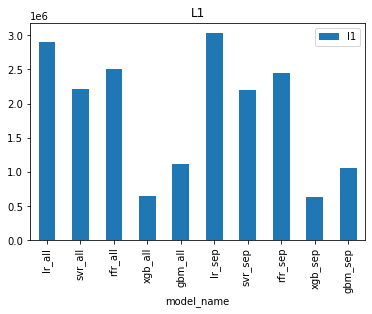

In [18]:
df.plot.bar(x='model_name', y='l1')
plt.title('L1')

Text(0.5, 1.0, 'L2')

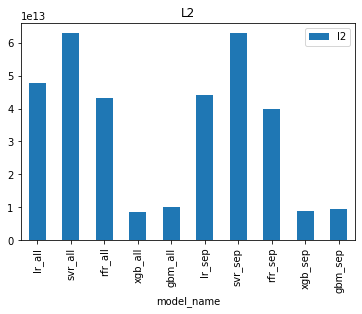

In [19]:
df.plot.bar(x='model_name', y='l2')
plt.title('L2')

Text(0.5, 1.0, 'R2')

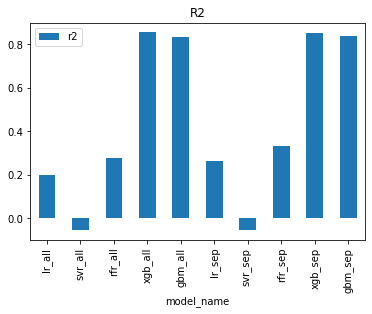

In [20]:
df.plot.bar(x='model_name', y='r2')
plt.title('R2')

Text(0.5, 1.0, 'RMSE')

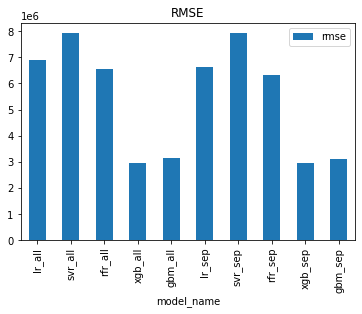

In [21]:
df.plot.bar(x='model_name', y='rmse')
plt.title('RMSE')

So we can see that including these definitively does not help the models. Examine the axis of this and compare to model_anaysis.ipynb. We can also check it's weight for the linear regression.